# Model Selection
## model_1 (intrinsic noise only) vs. model_2a (red noise + common red noise process)

* In this file, we will discuss using a HyperModel (multi-model) object from `enterprise_extensions`,
* and find odds ratios between two models: model_1 and model_2a.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

Do not have mpi4py package.


## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print('datadir =', datadir)

datadir = ../../data


In [3]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [4]:
# check for file and load pickle if it exists:
pickle_loc = datadir + '/psrs.pkl'
if os.path.exists(pickle_loc):
    with open(pickle_loc, 'rb') as f:
        psrs = pickle.load(f)

# else: load them in slowly:
else:
    psrs = []
    ephemeris = 'DE438'
    for p, t in zip(parfiles, timfiles):
        psr = Pulsar(p, t, ephem=ephemeris)
        psrs.append(psr)

In [5]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

* We want to compute the Bayesian odds for a signal in the data. This can be done using the `HyperModel` class, where we choose between a `model_2a` with a common (but uncorrelated) red process in the pulsars, and `model_1` with only intrinsic red noise in the model.

* We typically perform detection-type analyses with uniform-in-log priors on all amplitude parameters for low-frequency processes. This is implemented below with the argument `upper_limit` set to `False`.

## Setup dictionary of PTA models
* `model_1` consists of a PTA with only intrinsic red noise
* `model_2a` includes a common red noise process where, for this analysis, we set the spectral index to 13/3
* We also change `n_gwbfreqs` to only include the lowest 5 frequencies to match the 12.5 year stochastic gravitational wave background search
* There are other model functions built into `enterprise_extensions`.
* See the documentation of each function in the `models.py` file of `enterprise_extensions` for more information.

In [7]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_1(psrs, psd='powerlaw', noisedict=params)
pta[1] = models.model_2a(psrs, psd='powerlaw', noisedict=params, n_gwbfreqs=5, gamma_common=13/3)

* In setting up the `HyperModel` in the next cell, we set `log_weights` to make the models sample more evenly.
* This will be taken into account when we compute the posterior odds ratio later.
* `log_weights` is a list with the same length as the models, and each entry is added to the corresponding log-likelihood
* To undo the weights, we will divide each fraction by the exponential of the `log_weights`
* In this case, this corresponds to multiplying the odds ratio by $e^{10}$.

In [8]:
super_model = hypermodel.HyperModel(pta, log_weights=[10, 0])

## Sample

In [9]:
outDir = '../../chains/model_chains'
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [10]:
# This will take about an hour to sample
# To sample it properly will take ~30 hours
# sampler for N steps

# Uncomment the final line here to sample.
# Samples have been included with this tutorial set to save time and computation
N = int(5e6)  # 5e6 is a good number for a real analysis 
x0 = super_model.initial_sample()
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [14]:
chain = np.loadtxt(outDir + '/chain_1.txt')
burn = int(0.25 * chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

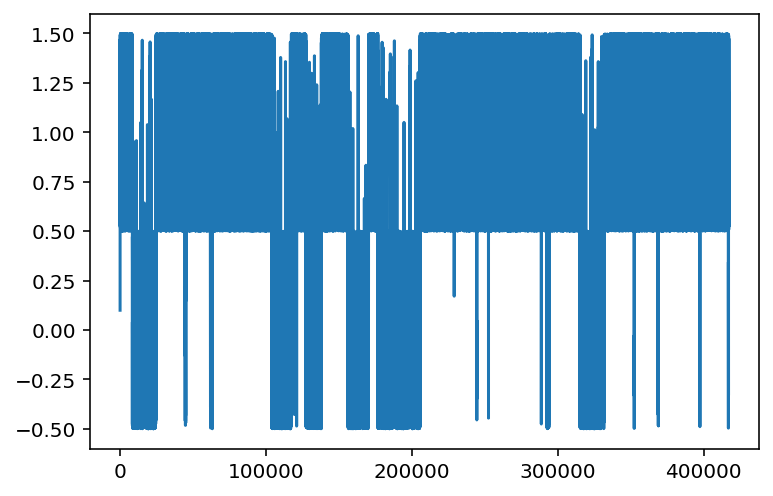

In [15]:
# Make trace-plot to diagnose sampling
ind_model = list(pars).index('nmodel')
plt.plot(chain[:, ind_model])

In [12]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

# ORF = None
# plt.plot(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp])
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=60);

NameError: name 'burn' is not defined

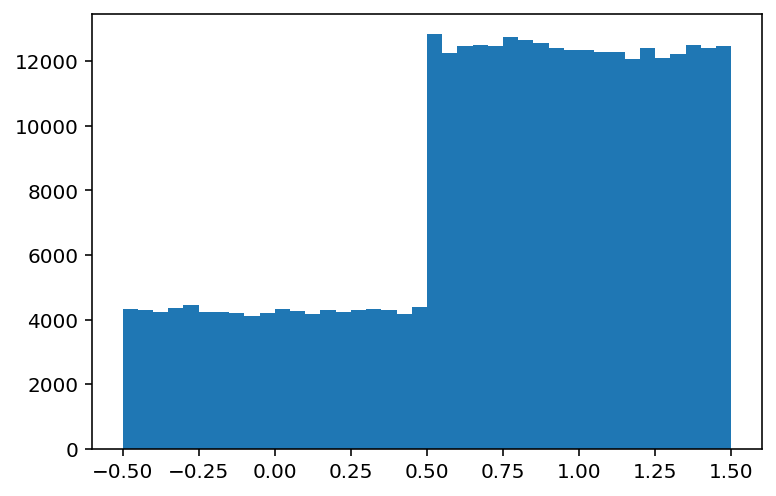

In [17]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.hist(chain_burn[:, ind_model], bins=40);

### Hypermodel
* The hypermodel overwhelmingly favors the second model (nmodel > 0.5)

### Posterior odds ratio

* This gives the Bayesian odds between a model with no red process between pulsars (`model_1`), and a common (but uncorrelated) red process between pulsars (`model_2a`). 
* This will tell us if the pulsars prefer a common red noise term over no common term, but it will not tell us if this is the GWB.
* We will return to this in the next section to compare between a common (uncorrelated) red noise term and a red noise term with Hellings and Downs (HD) correlations.
* HD correlations would indicate that the common signal is a gravitational wave background.
* The Bayes Factor here indicates that there is **strong** evidence for a common red noise signal among pulsars

In [18]:
# The first number is the Bayes factor (BF) and the second number is the uncertainty on the BF
bf, unc = model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1])
print(bf, unc)

2.910232383808096 0.34397760460409227


In [21]:
log10bf = np.log10(bf*np.exp(8))  # we multiply by exp(8) to undo the log_weight of 8
print(log10bf)

3.938283524272421


* Note that this Bayes factor is still a little low compared to the value found in the paper
* With more pulsars in the data set, we could recover the full log10BF of 4.5 for the `DE438` ephemeris.

In [10]:
with open('../../chains_mortimer/model_chains/chain_1.0.txt', 'r') as f:
    chain = np.loadtxt(f)

In [13]:
print(len(chain))

455400


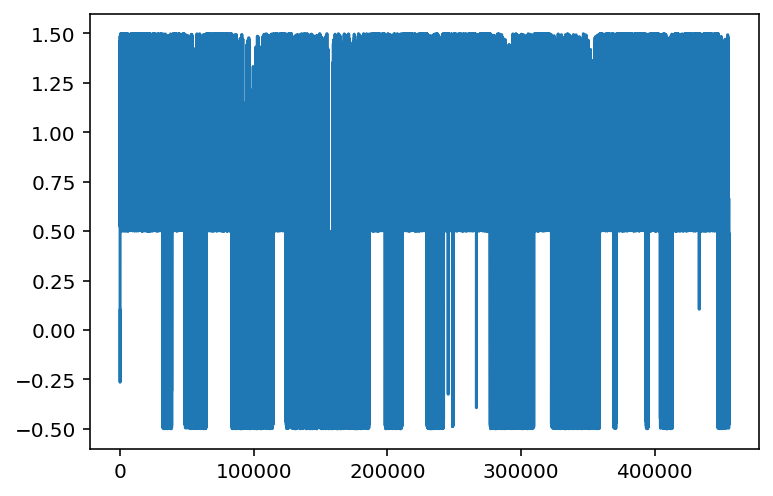

In [14]:
plt.plot(chain[:,-5])